<a href="https://colab.research.google.com/github/KIRTIRAJ4327/30days-AI-challenge/blob/main/Day14_Smart_Shopping_List.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Core Concept**

The focus is on predictive analytics - building a tool that predicts items you need to buy based on past purchases.

**Let's install the necessary libraries**

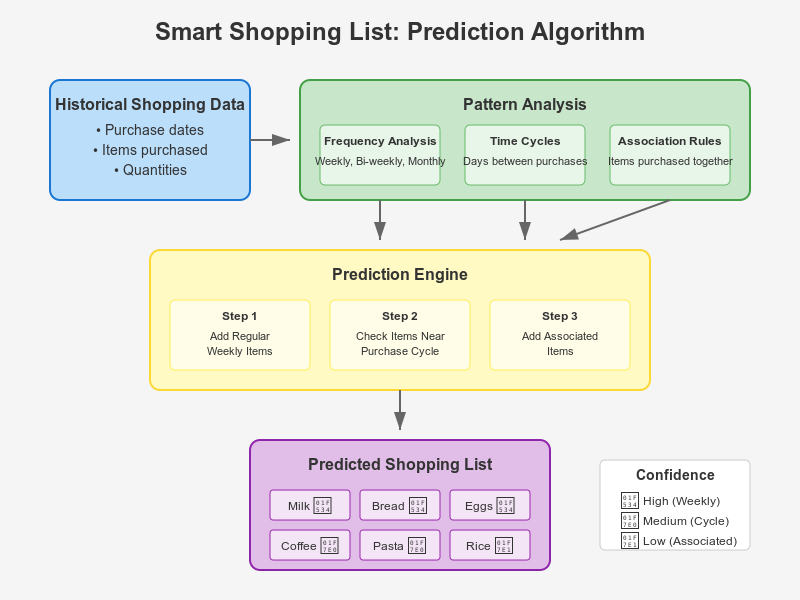

In [1]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn mlxtend

**Create Sample Shopping Data**

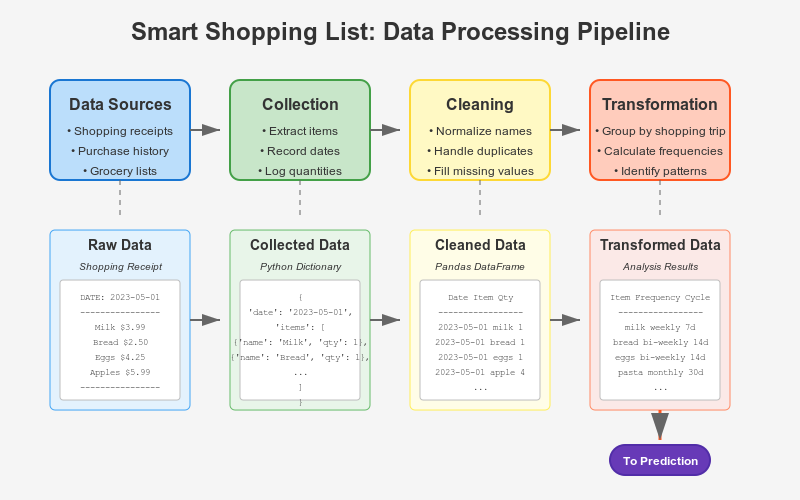

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Set a seed for reproducibility
np.random.seed(42)

# Define some common grocery items
grocery_items = [
    'Milk', 'Bread', 'Eggs', 'Apples', 'Bananas', 'Chicken', 'Pasta',
    'Tomato Sauce', 'Cereal', 'Coffee', 'Toilet Paper', 'Cheese', 'Yogurt',
    'Rice', 'Onions', 'Potatoes', 'Ground Beef', 'Lettuce', 'Carrots', 'Orange Juice'
]

# Create shopping dates (weekly shopping for 3 months)
start_date = datetime(2023, 1, 1)
dates = [start_date + timedelta(days=7*i) for i in range(12)]  # 12 weeks of shopping

# Create empty list to store shopping data
shopping_data = []

# Generate shopping data with realistic patterns
for i, date in enumerate(dates):
    # Weekly items (always buy)
    items = ['Milk']

    # Bi-weekly items
    if i % 2 == 0:  # even weeks
        items.extend(['Bread', 'Eggs', 'Apples'])
    else:  # odd weeks
        items.extend(['Cereal', 'Bananas', 'Coffee'])

    # Monthly items
    if i % 4 == 0:  # every 4 weeks
        items.extend(['Toilet Paper', 'Rice'])

    # Bi-monthly items
    if i % 8 == 0:  # every 8 weeks
        items.extend(['Laundry Detergent'])

    # Associated items (pasta always bought with tomato sauce)
    if i % 3 == 0:  # every 3 weeks
        items.extend(['Pasta', 'Tomato Sauce'])

    # Add some randomness (occasional purchases)
    random_items = np.random.choice(
        [item for item in grocery_items if item not in items],
        size=np.random.randint(0, 3),
        replace=False
    )
    items.extend(random_items)

    # Add each item as a separate row in our shopping list
    for item in items:
        shopping_data.append({
            'Date': date,
            'Item': item,
            'Quantity': np.random.randint(1, 4)  # Random quantity between 1-3
        })

# Create DataFrame
shopping_df = pd.DataFrame(shopping_data)

# Display the first few rows
print(shopping_df.head(10))

# Save information about when each trip happened
shopping_dates = shopping_df['Date'].unique()
print(f"\nShopping trips: {len(shopping_dates)} trips")

        Date               Item  Quantity
0 2023-01-01               Milk         3
1 2023-01-01              Bread         2
2 2023-01-01               Eggs         1
3 2023-01-01             Apples         2
4 2023-01-01       Toilet Paper         2
5 2023-01-01               Rice         2
6 2023-01-01  Laundry Detergent         2
7 2023-01-01              Pasta         1
8 2023-01-01       Tomato Sauce         1
9 2023-01-01       Orange Juice         2

Shopping trips: 12 trips


**Explore and Visualize the Data**


Total number of items purchased: 78
Unique items purchased: 17

Most frequently purchased items:
Item
Milk            12
Apples           7
Cereal           7
Eggs             6
Bread            6
Bananas          6
Coffee           6
Toilet Paper     5
Rice             4
Pasta            4
Name: count, dtype: int64


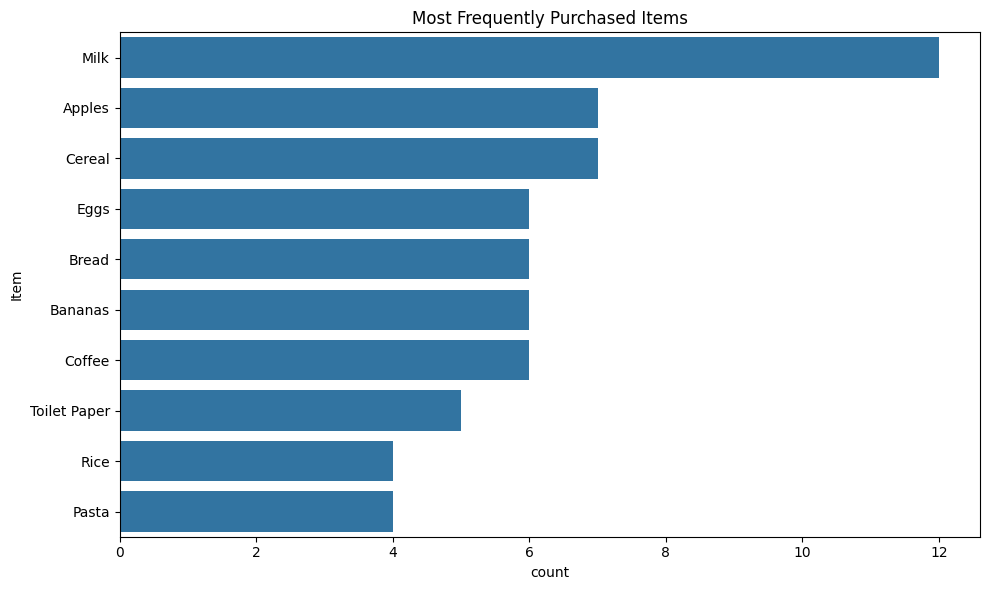

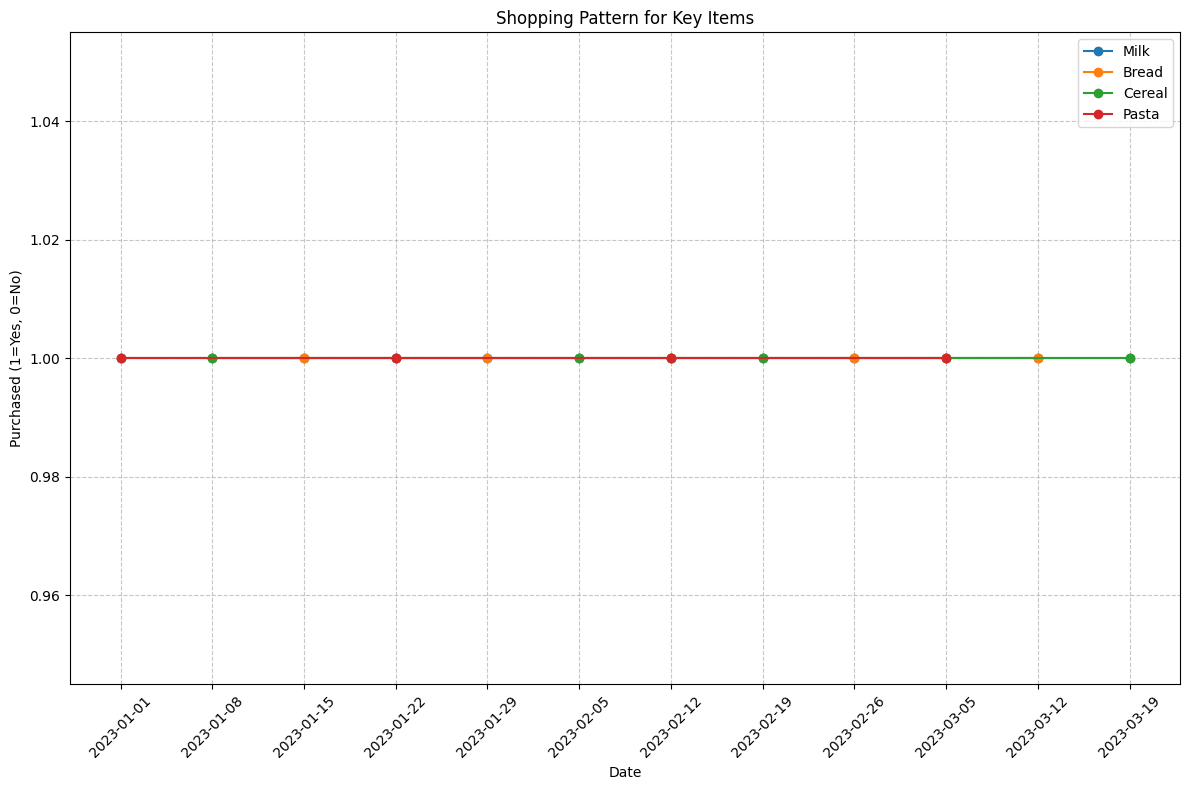

In [3]:
# Basic statistics
print("\nTotal number of items purchased:", len(shopping_df))
print("Unique items purchased:", shopping_df['Item'].nunique())

# Items frequency
item_counts = shopping_df['Item'].value_counts()
print("\nMost frequently purchased items:")
print(item_counts.head(10))

# Visualize purchasing patterns
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(y='Item', data=shopping_df, order=item_counts.index[:10])
plt.title('Most Frequently Purchased Items')
plt.tight_layout()
plt.show()

# Check the shopping pattern over time for a few key items
key_items = ['Milk', 'Bread', 'Cereal', 'Pasta']
plt.figure(figsize=(12, 8))

for item in key_items:
    item_data = shopping_df[shopping_df['Item'] == item]
    item_dates = [date.strftime('%Y-%m-%d') for date in item_data['Date']]
    trip_counts = pd.Series(1, index=item_dates).groupby(level=0).sum()

    plt.plot(trip_counts.index, trip_counts.values, marker='o', label=item)

plt.title('Shopping Pattern for Key Items')
plt.xlabel('Date')
plt.ylabel('Purchased (1=Yes, 0=No)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Find Item Purchase Patterns**

In [4]:
# Create functions to detect patterns
def analyze_purchase_frequency(df):
    """Analyze how frequently items are purchased."""
    # Group by item and count unique dates
    item_frequency = df.groupby('Item')['Date'].nunique().reset_index()
    item_frequency.columns = ['Item', 'Purchase_Frequency']

    # Calculate days between purchases (on average)
    total_days = (df['Date'].max() - df['Date'].min()).days
    item_frequency['Avg_Days_Between_Purchases'] = total_days / item_frequency['Purchase_Frequency']

    return item_frequency.sort_values('Purchase_Frequency', ascending=False)

# Calculate purchase frequencies
purchase_frequency = analyze_purchase_frequency(shopping_df)
print("\nPurchase frequency for all items:")
print(purchase_frequency)

# Find items that are typically bought together (association rules)
from mlxtend.frequent_patterns import apriori, association_rules

# Prepare data for association rule mining
# Create a pivot table: each row is a shopping trip, each column is an item
basket = pd.crosstab(shopping_df['Date'], shopping_df['Item'])
basket_sets = (basket > 0).astype(int)

# Apply the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support=0.2, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

print("\nAssociation rules between items:")
print(rules[['antecedents', 'consequents', 'support', 'confidence']])


Purchase frequency for all items:
                 Item  Purchase_Frequency  Avg_Days_Between_Purchases
10               Milk                  12                    6.416667
0              Apples                   7                   11.000000
4              Cereal                   7                   11.000000
2               Bread                   6                   12.833333
1             Bananas                   6                   12.833333
7                Eggs                   6                   12.833333
6              Coffee                   6                   12.833333
15       Toilet Paper                   5                   15.400000
14               Rice                   4                   19.250000
16       Tomato Sauce                   4                   19.250000
12              Pasta                   4                   19.250000
9             Lettuce                   3                   25.666667
3             Carrots                   2              

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


**Build the Prediction Model**


Predicted shopping list for next trip:
            Item Confidence                                             Reason
0           Milk       High                            Regular weekly purchase
1         Apples       High  Usually purchased every 11.0 days, last purcha...
2          Bread       High  Usually purchased every 12.8 days, last purcha...
3           Eggs       High  Usually purchased every 12.8 days, last purcha...
4   Toilet Paper       High  Usually purchased every 15.4 days, last purcha...
5   Tomato Sauce       High  Usually purchased every 19.2 days, last purcha...
6          Pasta       High  Usually purchased every 19.2 days, last purcha...
7        Lettuce       High  Usually purchased every 25.7 days, last purcha...
8         Cereal        Low                         Often purchased with Pasta
9           Rice        Low          Often purchased with Apples, Toilet Paper
10       Bananas        Low                        Often purchased with Cereal
11        Co

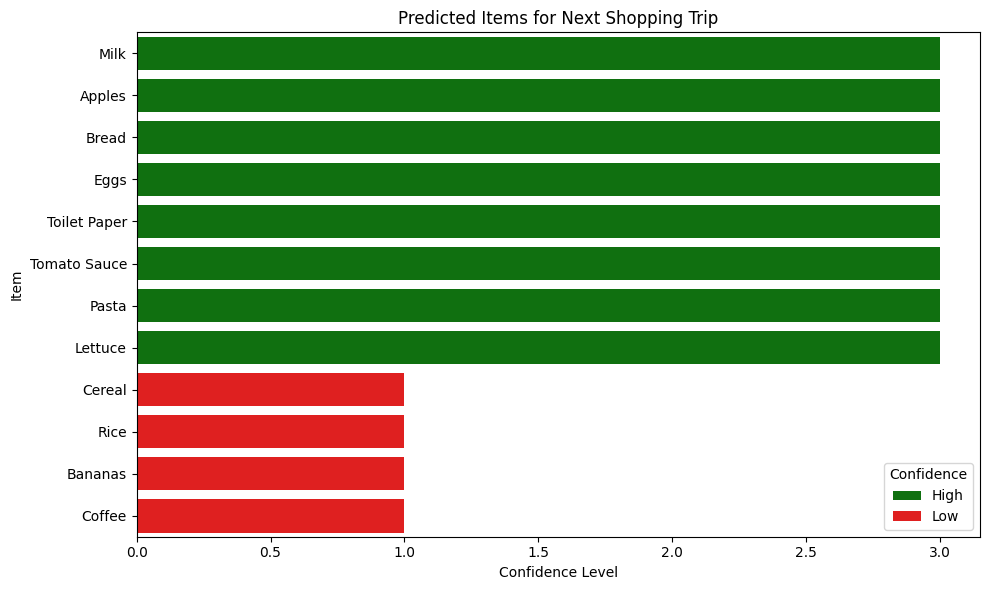

In [7]:
def predict_next_shopping_list(df, last_date, frequency_data, association_rules_data, confidence_threshold=0.7):
    """
    Predict items for the next shopping trip.

    Parameters:
    df - Shopping history DataFrame
    last_date - Date of the last shopping trip
    frequency_data - DataFrame with item purchase frequencies
    association_rules_data - DataFrame with association rules
    confidence_threshold - Minimum confidence for associations to consider

    Returns:
    List of predicted items with confidence scores
    """
    # Next shopping date (assuming weekly shopping)
    next_date = last_date + timedelta(days=7)

    predictions = []

    # 1. Check weekly items (items bought in more than 80% of trips)
    weekly_items = frequency_data[frequency_data['Purchase_Frequency'] >= 0.8 * len(df['Date'].unique())]
    for _, item_row in weekly_items.iterrows():
        predictions.append({
            'Item': item_row['Item'],
            'Confidence': 'High',
            'Reason': 'Regular weekly purchase'
        })

    # 2. Check bi-weekly and monthly patterns
    for _, item_row in frequency_data.iterrows():
        item = item_row['Item']

        # Skip already added weekly items
        if item in [p['Item'] for p in predictions]:
            continue

        # Get dates when this item was purchased
        purchase_dates = df[df['Item'] == item]['Date'].unique()

        # If less than 2 purchases, we can't establish a pattern
        if len(purchase_dates) < 2:
            continue

        # Calculate average days between purchases for this item
        avg_days = item_row['Avg_Days_Between_Purchases']

        # Find the most recent purchase date for this item
        last_purchase = max(purchase_dates)

        # Calculate days since last purchase
        days_since_purchase = (next_date - last_purchase).days

        # If we're close to the average purchase cycle, add to predictions
        if days_since_purchase >= 0.8 * avg_days:
            # Higher confidence if closer to expected purchase date
            confidence = min(1.0, days_since_purchase / avg_days)

            if confidence > 0.8:
                confidence_label = 'High'
            elif confidence > 0.5:
                confidence_label = 'Medium'
            else:
                confidence_label = 'Low'

            predictions.append({
                'Item': item,
                'Confidence': confidence_label,
                'Reason': f'Usually purchased every {avg_days:.1f} days, last purchased {days_since_purchase} days ago'
            })

    # 3. Add associated items based on rules
    items_already_predicted = [p['Item'] for p in predictions]

    for _, rule in association_rules_data.iterrows():
        # Skip rules with low confidence
        if rule['confidence'] < confidence_threshold:
            continue

        # If we've predicted the antecedent items but not the consequent, add the consequent
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])

        if (all(ant in items_already_predicted for ant in antecedents) and
            not any(cons in items_already_predicted for cons in consequents)):

            for cons in consequents:
                predictions.append({
                    'Item': cons,
                    'Confidence': 'Medium' if rule['confidence'] > 0.9 else 'Low',
                    'Reason': f'Often purchased with {", ".join(antecedents)}'
                })
                items_already_predicted.append(cons)

    return predictions

# Make predictions for next shopping trip
last_shopping_date = shopping_dates[-1]
predictions = predict_next_shopping_list(shopping_df, last_shopping_date, purchase_frequency, rules)

# Display predictions
prediction_df = pd.DataFrame(predictions)
print("\nPredicted shopping list for next trip:")
print(prediction_df)

# Visualize predictions
plt.figure(figsize=(10, 6))
prediction_df['Confidence_Value'] = prediction_df['Confidence'].map({'High': 3, 'Medium': 2, 'Low': 1})
prediction_df = prediction_df.sort_values('Confidence_Value', ascending=False)

# Update the palette to include colors for 'High', 'Medium', and 'Low'
ax = sns.barplot(x='Confidence_Value', y='Item', data=prediction_df,
                 palette={'High': 'green', 'Medium': 'orange', 'Low': 'red'},  # Updated palette
                 hue='Confidence', dodge=False)

plt.title('Predicted Items for Next Shopping Trip')
plt.xlabel('Confidence Level')
plt.ylabel('Item')
plt.tight_layout()
plt.show()

**Evaluate the Prediction Model**


Training data: 9 shopping trips
Testing data: 3 shopping trips


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)



Evaluation results:
        Date  Precision    Recall  F1_Score
0 2023-03-12   0.416667  1.000000  0.588235
1 2023-03-19   0.333333  0.666667  0.444444
Average Precision: 0.38
Average Recall: 0.83
Average F1 Score: 0.52


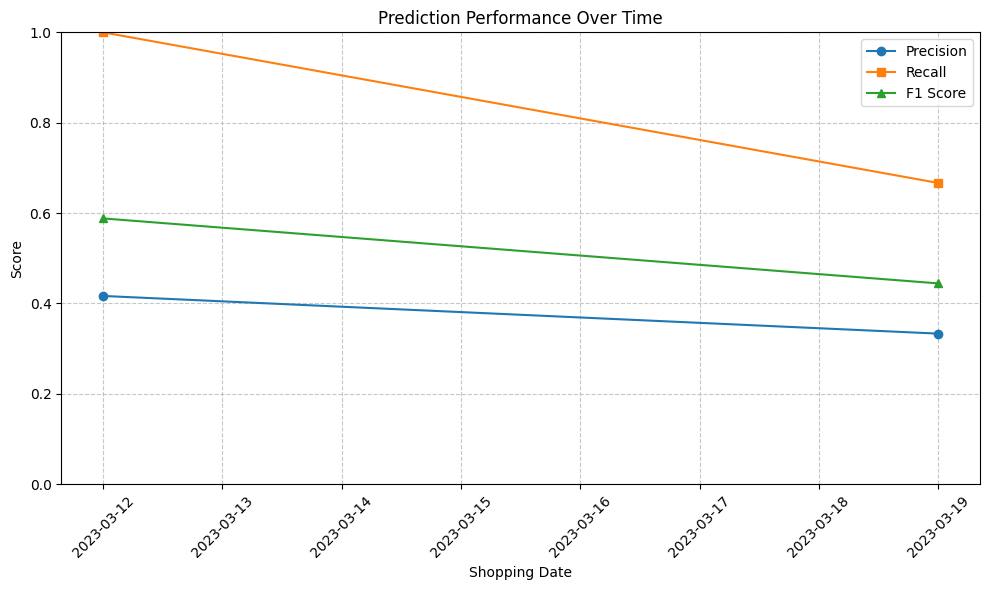

In [8]:
# Function to split our data into training and testing sets
def split_shopping_data(df, test_ratio=0.25):
    # Sort by date
    df_sorted = df.sort_values('Date')

    # Get unique shopping dates
    unique_dates = df_sorted['Date'].unique()
    split_idx = int(len(unique_dates) * (1 - test_ratio))

    # Split dates
    train_dates = unique_dates[:split_idx]
    test_dates = unique_dates[split_idx:]

    # Split dataframes
    train_df = df_sorted[df_sorted['Date'].isin(train_dates)]
    test_df = df_sorted[df_sorted['Date'].isin(test_dates)]

    return train_df, test_df, train_dates, test_dates

# Split our data
train_df, test_df, train_dates, test_dates = split_shopping_data(shopping_df)
print(f"\nTraining data: {len(train_dates)} shopping trips")
print(f"Testing data: {len(test_dates)} shopping trips")

# Calculate purchase frequencies on training data
train_frequency = analyze_purchase_frequency(train_df)

# Create association rules on training data
train_basket = pd.crosstab(train_df['Date'], train_df['Item'])
train_basket_sets = (train_basket > 0).astype(int)
train_frequent_itemsets = apriori(train_basket_sets, min_support=0.2, use_colnames=True)
train_rules = association_rules(train_frequent_itemsets, metric="confidence", min_threshold=0.7)

# Evaluate predictions for each test date
evaluation_results = []

for i in range(len(test_dates) - 1):
    # Make prediction for test_date using data up to the previous test date
    last_date = test_dates[i]
    actual_date = test_dates[i + 1]

    # Get predictions
    predictions = predict_next_shopping_list(train_df, last_date, train_frequency, train_rules)
    predicted_items = [p['Item'] for p in predictions]

    # Get actual items purchased
    actual_items = test_df[test_df['Date'] == actual_date]['Item'].unique().tolist()

    # Calculate accuracy metrics
    correct_predictions = [item for item in predicted_items if item in actual_items]
    false_positives = [item for item in predicted_items if item not in actual_items]
    false_negatives = [item for item in actual_items if item not in predicted_items]

    precision = len(correct_predictions) / len(predicted_items) if predicted_items else 0
    recall = len(correct_predictions) / len(actual_items) if actual_items else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    evaluation_results.append({
        'Date': actual_date,
        'Predicted_Items': predicted_items,
        'Actual_Items': actual_items,
        'Correct_Predictions': correct_predictions,
        'False_Positives': false_positives,
        'False_Negatives': false_negatives,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    })

# Display evaluation metrics
eval_df = pd.DataFrame(evaluation_results)
print("\nEvaluation results:")
print(eval_df[['Date', 'Precision', 'Recall', 'F1_Score']])
print(f"Average Precision: {eval_df['Precision'].mean():.2f}")
print(f"Average Recall: {eval_df['Recall'].mean():.2f}")
print(f"Average F1 Score: {eval_df['F1_Score'].mean():.2f}")

# Visualize evaluation metrics
plt.figure(figsize=(10, 6))
plt.plot(eval_df['Date'], eval_df['Precision'], marker='o', label='Precision')
plt.plot(eval_df['Date'], eval_df['Recall'], marker='s', label='Recall')
plt.plot(eval_df['Date'], eval_df['F1_Score'], marker='^', label='F1 Score')
plt.title('Prediction Performance Over Time')
plt.xlabel('Shopping Date')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

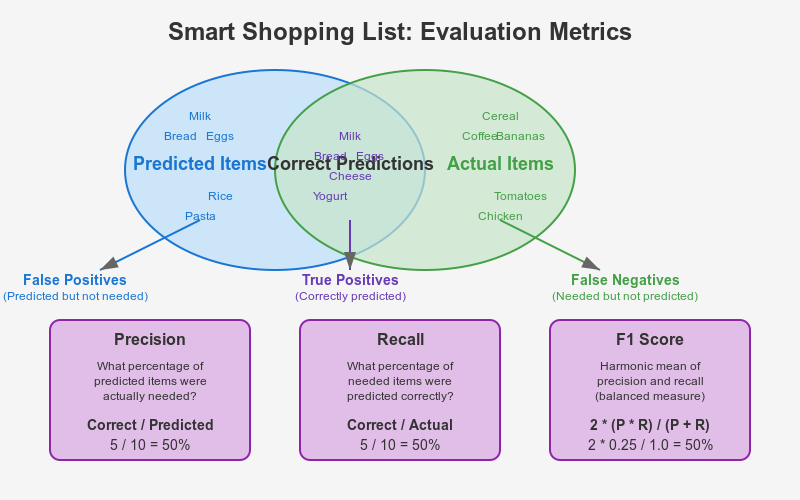

**Create a User-Friendly Display Function**

In [11]:
def display_shopping_list(predictions):
    """
    Format and display a shopping list in a user-friendly way.
    """
    # Sort by confidence level
    confidence_order = {'High': 1, 'Medium': 2, 'Low': 3}
    sorted_predictions = sorted(predictions, key=lambda x: confidence_order[x['Confidence']])

    # Group by confidence
    high_conf = [p for p in sorted_predictions if p['Confidence'] == 'High']
    medium_conf = [p for p in sorted_predictions if p['Confidence'] == 'Medium']
    low_conf = [p for p in sorted_predictions if p['Confidence'] == 'Low']

    print("\n===== YOUR SMART SHOPPING LIST =====")
    print(f"Predicted items for {(last_shopping_date + timedelta(days=7)).strftime('%A, %B %d')}")
    print("\n🔴 DEFINITELY NEED:")
    for item in high_conf:
        print(f"  ✓ {item['Item']}")
        print(f"    ({item['Reason']})")

    if medium_conf:
        print("\n🟠 PROBABLY NEED:")
        for item in medium_conf:
            print(f"  ✓ {item['Item']}")
            print(f"    ({item['Reason']})")

    if low_conf:
        print("\n🟡 MIGHT NEED:")
        for item in low_conf:
            print(f"  ✓ {item['Item']}")
            print(f"    ({item['Reason']})")

    print("\n=====================================")

# Display our final shopping list prediction
display_shopping_list(predictions)


===== YOUR SMART SHOPPING LIST =====
Predicted items for Sunday, March 26

🔴 DEFINITELY NEED:
  ✓ Milk
    (Regular weekly purchase)
  ✓ Apples
    (Usually purchased every 11.2 days, last purchased 21 days ago)
  ✓ Eggs
    (Usually purchased every 11.2 days, last purchased 21 days ago)
  ✓ Bread
    (Usually purchased every 11.2 days, last purchased 21 days ago)
  ✓ Cereal
    (Usually purchased every 11.2 days, last purchased 28 days ago)
  ✓ Coffee
    (Usually purchased every 14.0 days, last purchased 28 days ago)
  ✓ Toilet Paper
    (Usually purchased every 14.0 days, last purchased 21 days ago)
  ✓ Bananas
    (Usually purchased every 14.0 days, last purchased 28 days ago)
  ✓ Rice
    (Usually purchased every 18.7 days, last purchased 21 days ago)
  ✓ Tomato Sauce
    (Usually purchased every 18.7 days, last purchased 35 days ago)
  ✓ Pasta
    (Usually purchased every 18.7 days, last purchased 35 days ago)
  ✓ Lettuce
    (Usually purchased every 18.7 days, last purchased 42